## Identificando Agregação Espaço-Temporal
Werneck, Guilherme L., e Claudio J. Struchiner. “Estudos de agregados de doença no espaço-tempo: conceitos, técnicas e desafios”. Cadernos de Saúde Pública 13, nº 4 (outubro de 1997): 611–24. https://doi.org/10.1590/S0102-311X1997000400005.

> "Agregação espaço-temporal pode ser entendida como uma forma de não-aleatoriedade na distribuição da doença : em que, entre eventos próximos no tempo, existe um excesso não esperado de eventos que estão também próximos no espaço (McAullife & Afifi, 1984). Este conceito é distinto do de agregação espacial e temporal, e também tem sido denominado interação espaço-temporal (Knox, 1991; Jacquez et al., 1996). De fato, agregação espaço-temporal pode ocorrer na ausência de agregação espacial e temporal, ou mesmo estar ausente quando existe agregação nas duas dimensões (Estève et al., 1994)."

Seguindo o exemplo da publicação são criadas algumas visualizações a seguir para identificar agregação espaço-temporal.

São necessárias formas geométricas adquiridas no site do IBGE (apenas .shp, .shx e .dbf):

- https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/Brasil/BR/BR_Municipios_2020.zip
- Descompactar em `data/raw/poligonos`


In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data(ratio, shapes):
    '''
    | ratio: arquivo .csv com taxa de incidência ou outra medida anual para cada município identificado 
    | por código de 6 dígitos.
    |
    | shapes: arquivo de polígonos do IBGE para cada município identificado por código de 7 dígitos 
    | (necessário desconsiderar o último).
    | 
    | returns: dataframe `ratio` acrescido da média do último triênio (trienio) e a média de todos anos para cada
    | município; polígono de cada município (geometry).
    '''
    df = pd.read_csv(ratio).set_index('CO_MN_INF') 
   
    # *.shp vai utilizar o arquiv .shx e .dbf 
    shapes = gpd.read_file(shapes)
    shapes.CD_MUN = shapes.CD_MUN.apply(lambda x: x[0:6])
    shapes.CD_MUN = shapes.CD_MUN.astype(int)
    shapes = shapes.set_index('CD_MUN')
    
    anos = df.columns
    df['trienio'] = df.loc[:, anos[-3:]].mean(axis=1)    
    df['media'] = df.loc[:, anos].mean(axis=1)
    df['geometry'] = df.index.map(shapes['geometry'].to_dict())
    return df

def spatial_agregation(data, column='media'):
    temp_df = data.loc[:, [column, 'geometry']]
    if column == 'media':
        title = '2007 a 2019'
    elif column == 'trienio':
        title = '2017 a 2019'        
    elif column in data.columns[0:-3]:
        title = column        
        
    #para = para.loc[para.acumulado > data.mean(axis=1).mean(), :]
    #para['acumulado'] = (para.acumulado - para.acumulado.min()) / (para.acumulado.max() - para.acumulado.min())

    gdf = gpd.GeoDataFrame(temp_df.replace(0, np.nan), geometry='geometry', crs="EPSG:4326")
    fig, ax = plt.subplots(figsize=(15,9))
    plt.rcParams['font.size'] = 12
    gdf.plot(
        column=column, 
        ax=ax,
        cmap = plt.cm.Oranges,            
        scheme='equalinterval',
        k=8,
        legend = True,
        missing_kwds={
            'color': 'white',
            'edgecolor': 'gray',
            'hatch': '///',
            'label': 'Sem casos registrados'
        }
    )
    ax.set_title(
        f'''Agregação espacial
        Média do período {title}
        ''', 
        fontdict = {'fontsize':22, 'color':'darkblue'}
    )
    ax.set_axis_off()
    #move legend to an empty space
    ax.get_legend().set_bbox_to_anchor((1.25,.40))
    fig.savefig(f'../images/spatial-{title}.png', dpi=fig.dpi)
    plt.show()
    display(mapclassify.classifiers.EqualInterval(gdf[column], k=8))

def temporal_agregation(data):
    temp_df = data.loc[:, anos].mean(axis=0)

    #se aumentou mais que 50% em relação a media de todos anos (critério aleatório)
    clrs = ['indianred' if (temp_df.iloc[i] / temp_df.iloc[:i].mean()) > 1.5 else 'cornflowerblue' for i in range(1, temp_df.size)]  
    clrs.insert(0, 'cornflowerblue')
    fig, ax = plt.subplots(figsize=(15,9))
    plt.rcParams['font.size'] = 12
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    temp_df.plot(
        kind='bar',
        ax=ax,
        color=clrs
    )
    temp_df.plot(
        kind='line',
        ax=ax
    )
    plt.xticks(rotation=45, ha='right')
    ax.set_title(
        '''Incidência média por ano (casos por 100.000 hab.)
        Agregação temporal de casos\n''', 
        fontdict = {'fontsize':22, 'color':'darkblue'}
    )
    fig.savefig('../images/temporal.png', dpi=fig.dpi)
    plt.show()
    
def spatial_temporal_agregation(data, region='mesorregiao'):
    group = data.groupby('mesorregiao')[anos].mean()
    group['mean'] = group.mean(axis=1)
    group = group.sort_values(ascending=False,by='mean')
    group = group.drop('mean',axis=1)
    #display(group)
    fig, ax = plt.subplots(1, figsize=(16, 10))
    plt.rcParams['font.size'] = 12
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    ax.set_title(
        '''Incidência média por ano de cada mesorregião
        Agregação temporal e espacial de casos\n''', 
        fontdict = {'fontsize':22,'color':'darkblue'}
    )
    #move legend to an empty space
    group.T.plot(kind='bar', stacked=True, ax=ax, alpha=0.8)
    plt.xticks(rotation=45, ha='right')
    ax.get_legend().set_bbox_to_anchor((0.6,0.7))
    fig.savefig('../images/spatio-temporal.png', dpi=fig.dpi)    
    plt.show()  

In [3]:
#dados de municípios
mun = pd.read_csv('../data/processed/processed_municipios.csv') 

#dataframe com polígonos
ratio = '../data/indicadores/visceral/indicador_15_taxa_incidencia_municipio_infeccao.csv'
shapes = '../data/raw/poligonos/BR_Municipios_2020.shp'
df = load_data(ratio, shapes)

#dataframe somente Pará
idx_para = mun.loc[(mun.estado == 'Pará'), ['ibge_code', 'mesorregiao']].set_index('ibge_code')['mesorregiao'].to_dict()
para = df.loc[idx_para.keys(), :]
#adiciona a mesorregião de cada município
para['mesorregiao'] = para.index.map(idx_para)

#anos
anos = para.columns[0:13]

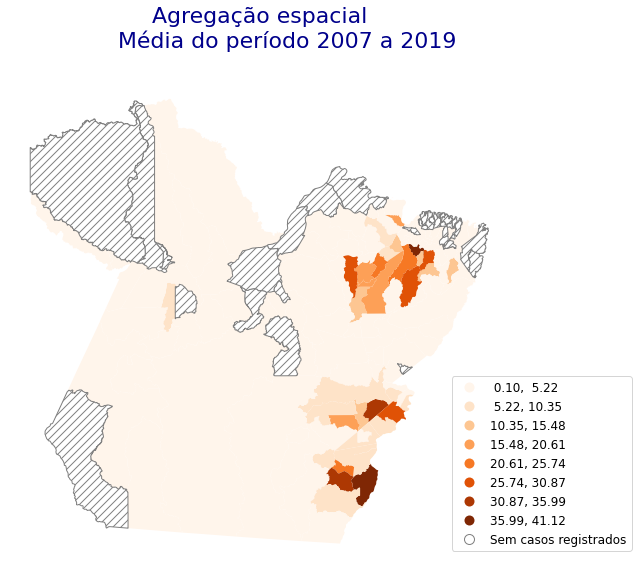

EqualInterval         

   Interval      Count
----------------------
[  nan,  5.22] |   109
( 5.22, 10.35] |    13
(10.35, 15.48] |     6
(15.48, 20.61] |     5
(20.61, 25.74] |     3
(25.74, 30.87] |     4
(30.87, 35.99] |     2
(35.99, 41.12] |     2

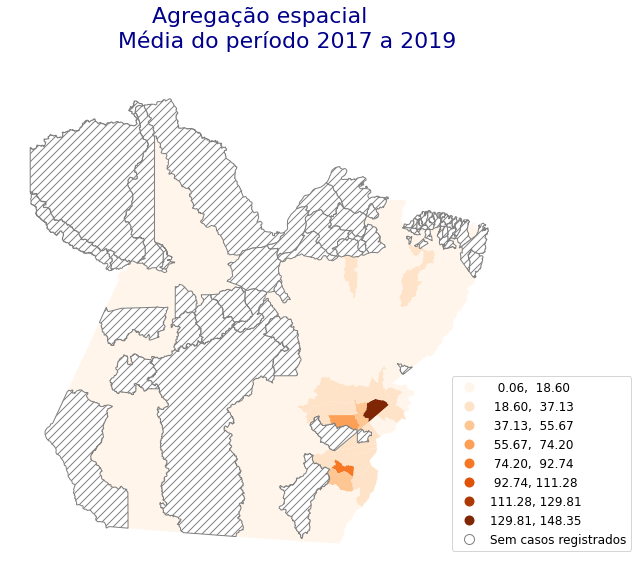

EqualInterval           

    Interval       Count
------------------------
[   nan,  18.60] |   126
( 18.60,  37.13] |    13
( 37.13,  55.67] |     2
( 55.67,  74.20] |     1
( 74.20,  92.74] |     1
( 92.74, 111.28] |     0
(111.28, 129.81] |     0
(129.81, 148.35] |     1

In [4]:
spatial_agregation(para)
spatial_agregation(para, 'trienio')

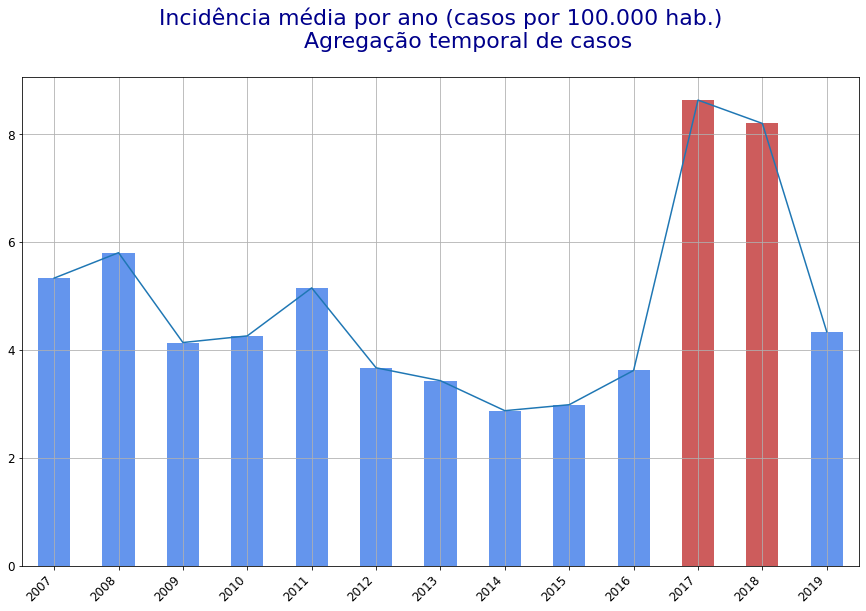

In [5]:
temporal_agregation(para)

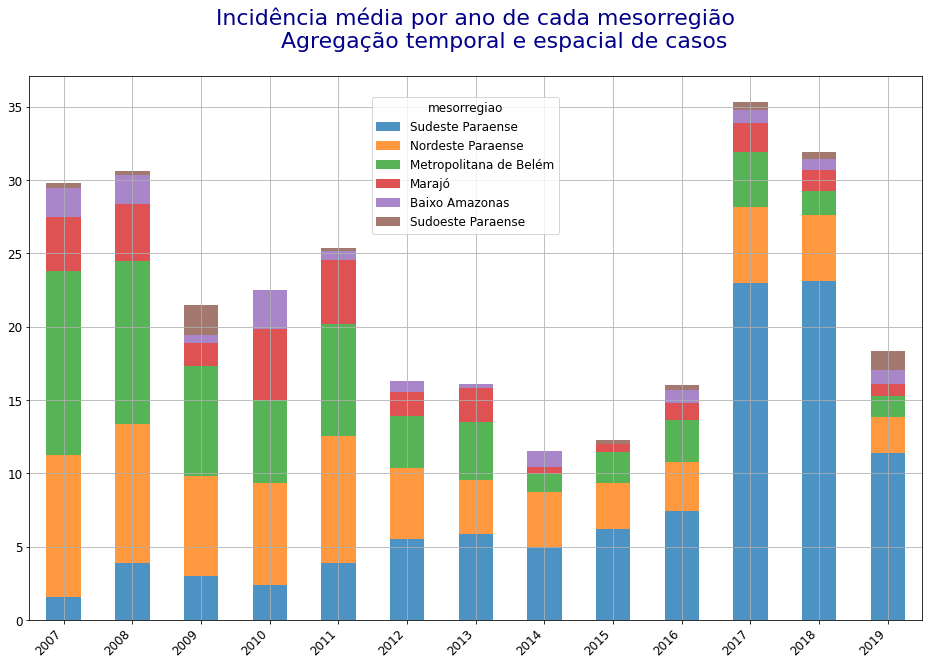

In [6]:
spatial_temporal_agregation(para)

## Testes Estatísticos

__Besag & Newell (1991), as técnicas para investigação de agregados espaciais e temporais podem ser divididas em dois subgrupos:__
- `testes de agregação (T1)`
    - gerais (T1-G): objetivam identificar um padrão geral de distribuição da doença em uma grande região.
    - focais (T1-F)
- `testes para detecção de agregados (T2)`
    - "são utilizados na vigilância rotineira de grandes quantidades de pequenas áreas, buscando evidenciar agregados pontuais de doença, porém sem preconcepção acerca de suas localizações."
    
    
__Técnicas avaliadas no artigo:__ 

- `Knox (Knox, 1964a)`,
- `Mantel (Mantel, 1967)`, 
- `McAuliffe (McAuliffe & Afifi, 1984)`, 
- `EMM (Ederer et al., 1964)`
- `Moran (Moran, 1948; Moran, 1950; Cliff & Ord, 1981)`

__As notificações não possuem coordenadas, das técnicas acima se encaixam as de testes de agregação `T1`:__
- `EMM`
- `Moran`

>  "A técnica de Moran é uma das mais comumente aplicadas no estudo de agregados espaciais, em geral acompanhando mapas de distribuição de doenças (Cliff & Ord, 1981; Walter, 1993)."

Observação: o artigo traz uma fórmula de Moran adaptada para análise de agregação espaço temporal.

## Avaliando Autocorrelação Espacial Global
Calculamos o I de Moran. Um teste de autocorrelação global para um atributo contínuo.

- Fonte: 
    - [download notebook:](http://pysal.org/notebooks/content/viz/splot/esda_morans_viz.ipynb)
    - [web page:](http://pysal.org/notebooks/viz/splot/esda_morans_viz.html)

In [7]:
from libpysal.weights.contiguity import Queen
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from esda.moran import Moran

In [8]:
w = Queen.from_dataframe(para)
w.transform = 'r'

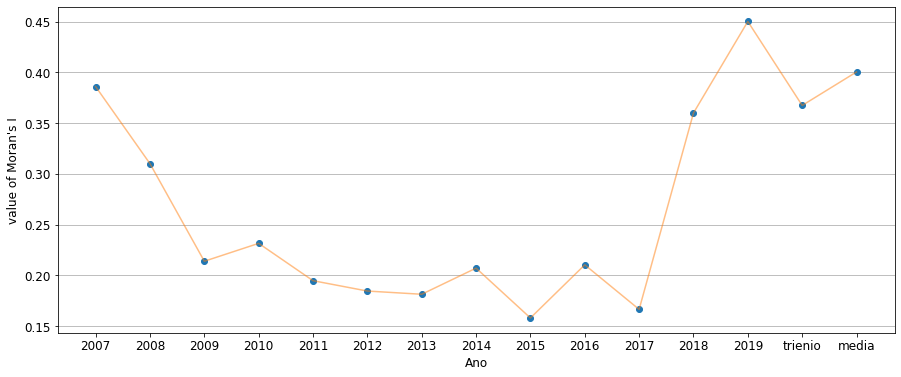

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,trienio,media
Moran I,0.385995,0.310011,0.21384,0.231469,0.194673,0.184476,0.181302,0.207063,0.157935,0.210316,0.166393,0.35993,0.45015,0.36739,0.400401
p value,0.001000,0.001000,0.00200,0.001000,0.003000,0.003000,0.004000,0.001000,0.004000,0.002000,0.014000,0.00100,0.00100,0.00100,0.001000


In [9]:
I = {}
for it in np.concatenate([anos, ['trienio', 'media']]):
    y = para.loc[:, it].values    
    moran = Moran(y, w)
    I.update({it: [moran.I, moran.p_sim]})
plt.figure(1 , figsize = (15 ,6))
plt.plot(I.keys() , [it[0] for it in I.values()] , 'o')
plt.plot(I.keys() , [it[0] for it in I.values()] , '-' , alpha = 0.5)
plt.xlabel('Ano') , plt.ylabel("value of Moran's I")
plt.show()
display(pd.DataFrame(I, index=['Moran I', 'p value']))

Nosso valor para a estatística é interpretado contra uma distribuição de referência sob a hipótese nula de aleatoriedade espacial completa. PySAL usa a abordagem de permutações espaciais aleatórias.

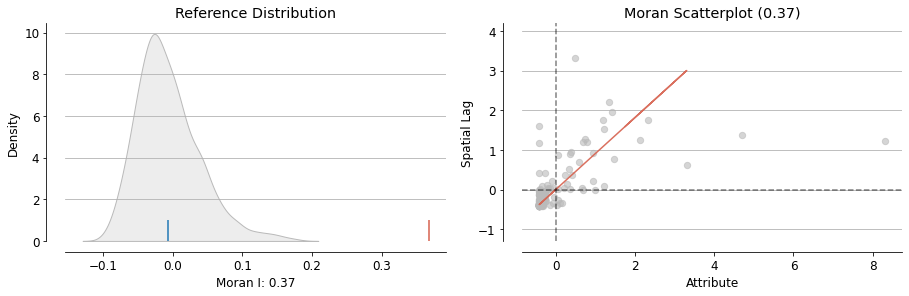

In [10]:
moran = Moran(para.loc[:, 'trienio'].values, w)
plot_moran(moran, zstandard=True, figsize=(15,4))
plt.show()

## Visualizando autocorrelação local com `splot` - pontos quentes, pontos frios e outliers espaciais
Além de visualizar estatísticas de autocorrelação global, o splot tem opções para visualizar estatísticas de autocorrelação locais. Calculamos o Moran `m` local. 

Podemos distinguir o tipo específico de autocorrelação espacial local em High-High, Low-Low, High-Low, Low-High. Onde o quadrante superior direito exibe HH, o inferior esquerdo, LL, o superior esquerdo LH e o inferior direito HL.

Esses tipos de autocorrelação espacial local descrevem semelhanças ou dissimilaridades entre um polígono específico com seus polígonos vizinhos. O quadrante superior esquerdo, por exemplo, indica que os polígonos com valores baixos são circundados por polígonos com valores altos (LH). O quadrante inferior direito mostra polígonos com valores altos cercados por vizinhos com valores baixos (HL). Isso indica uma associação de valores diferentes.

Vamos agora visualizar as áreas que consideramos significativas em um mapa:

In [11]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation
import warnings
warnings.filterwarnings('ignore')

In [12]:
gdf = gpd.GeoDataFrame(para, geometry='geometry', crs="EPSG:4326")

__Em 2007 e 2008 a autocorrelação espacial se concentra no nordeste do estado.__

2007


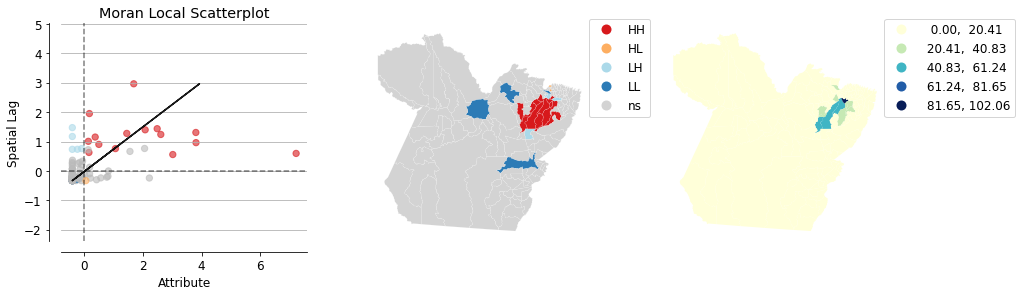

2008


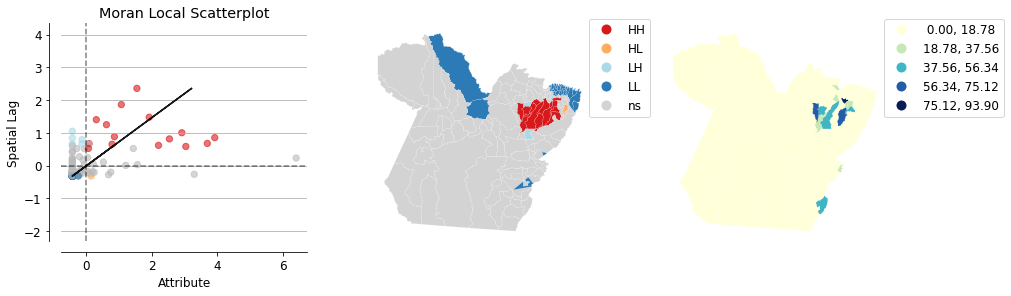

In [13]:
for ano in ['2007', '2008']:
    y = para.loc[:, ano].values
    moran_loc = Moran_Local(y, w) 
    print(f'{ano}')
    plot_local_autocorrelation(moran_loc, gdf, ano, scheme='EqualInterval')
    plt.show()

__Em 2008 a microrregião do Bico do Papagaio, em Tocantins, foi apontada como a de maior intensidade de transmissão. Em 2009 surge a primeira área com autocorrelação espacial alta no sudeste do Pará, sendo esta fronteiriça ao Bico do Papagaio.__
> "Um estudo realizado sobre a distribuição de LV no estado do Tocantins apontou a microrregião do Bico do Papagaio, fronteira entre estados de Tocantins, Maranhão e Pará, como a de maior intensidade na transmissão da doença no estado no ano de 2008."

2009


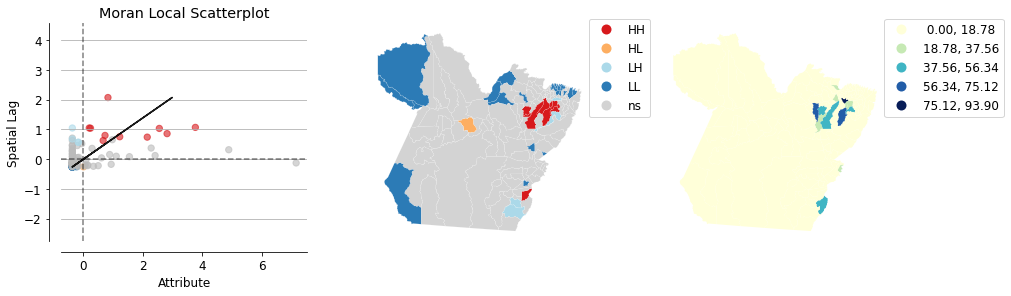

In [14]:
y = para.loc[:, '2009'].values
moran_loc = Moran_Local(y, w) 
print('2009')
plot_local_autocorrelation(moran_loc, gdf, ano, scheme='EqualInterval')
plt.show()

__Em 2011, ao mesmo tempo que a microrregião de Araguaína no Tocantins é identificada como a de transmissão mais intensa, um conjunto de municípios no sudeste do Pará, próximo à fronteira com esta mesma microrregião, é identificado no mapa abaixo como de elevada autocorrelação espacial.__
> " Em 2011 a microrregião com maior intensidade foi a de Araguaína. O autor atribui essa variação espacial à migração entre as microrregiões. Os três municípios mais afetados pela doença no período de estudo foram Araguatins, Araguaína e Ananás, todos próximos à fronteira com o sudeste do Pará (FONTOURA; FONTOURA; NASCIMENTO, 2016)."

2010


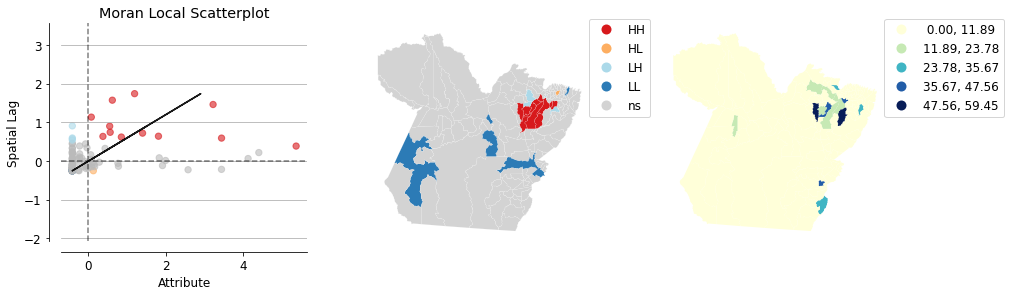

2011


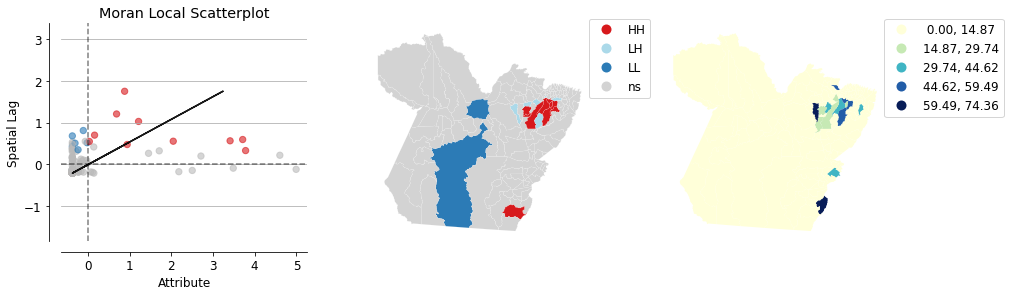

In [15]:
for ano in ['2010', '2011']:
    y = para.loc[:, ano].values
    moran_loc = Moran_Local(y, w) 
    print(f'{ano}')
    plot_local_autocorrelation(moran_loc, gdf, ano, scheme='EqualInterval')
    plt.show()

__Os dados mostram que a partir de 2009 surgem pontos de não aleatoriedade da distribuição da doença no sudeste do Pará inicialmente em municípios localizados na fronteira com Tocantins e se expandindo para outros municípios do sudeste nos anos seguintes.__

2012


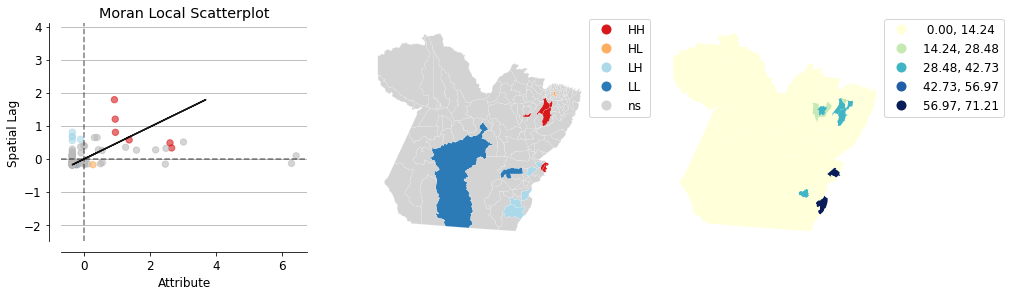

2013


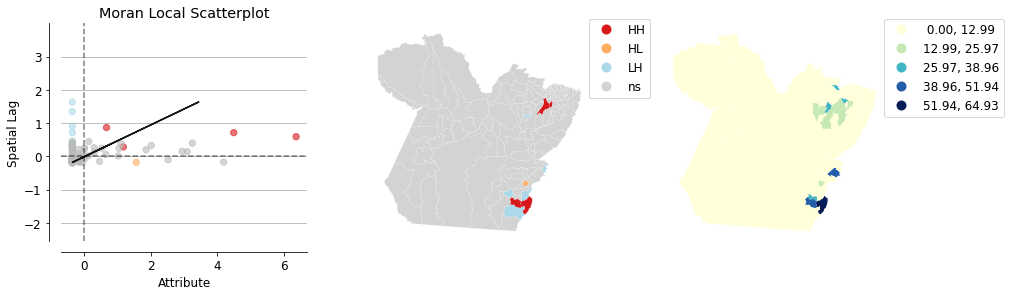

2014


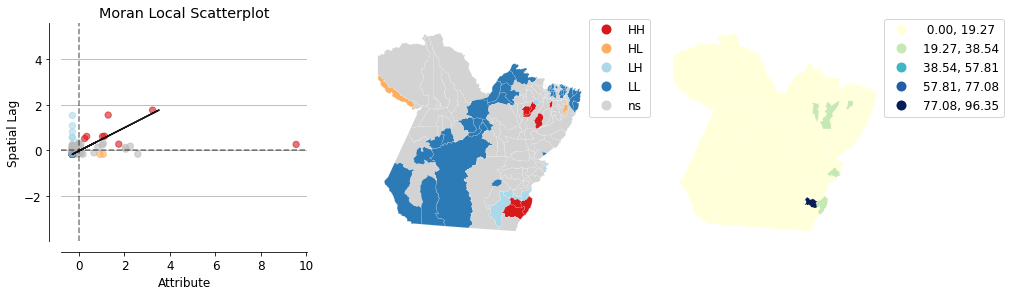

2015


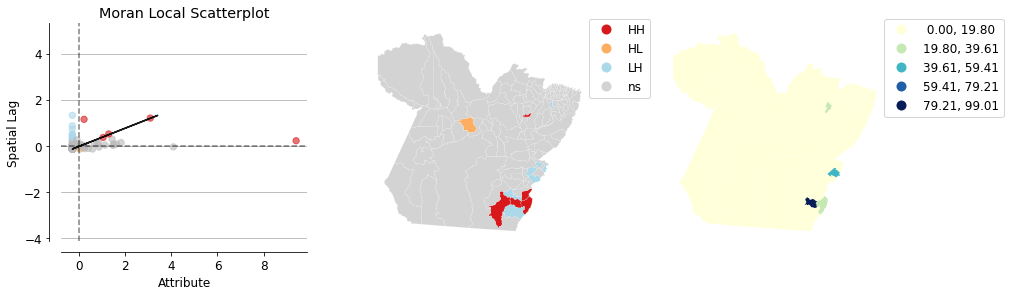

2016


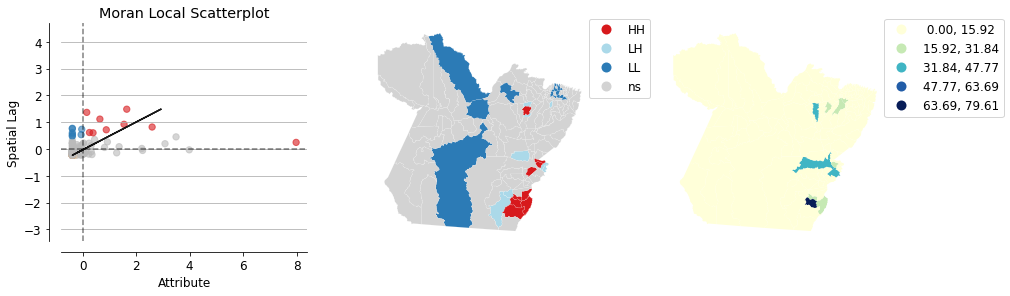

2017


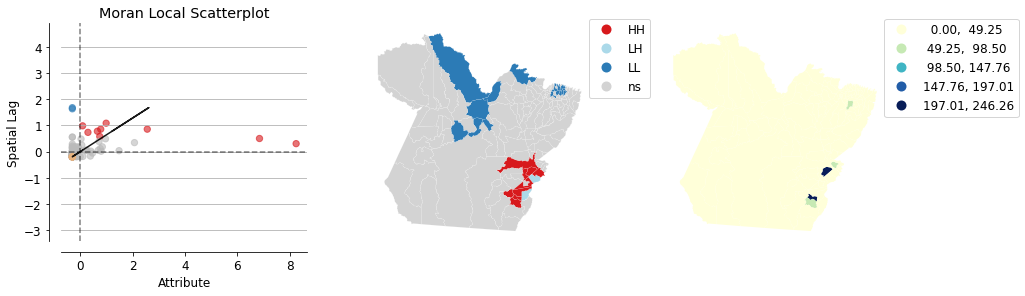

2018


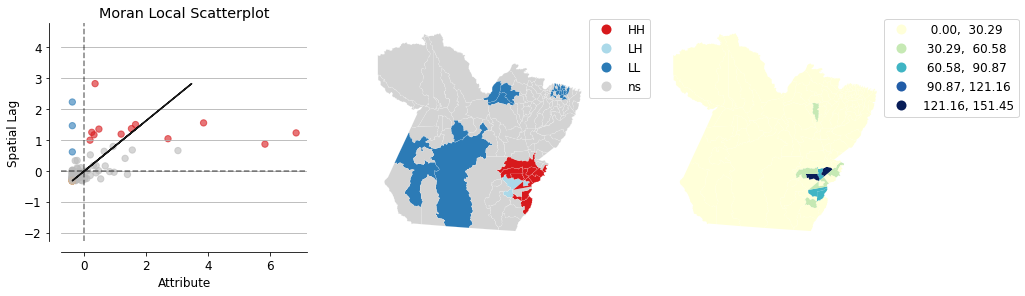

2019


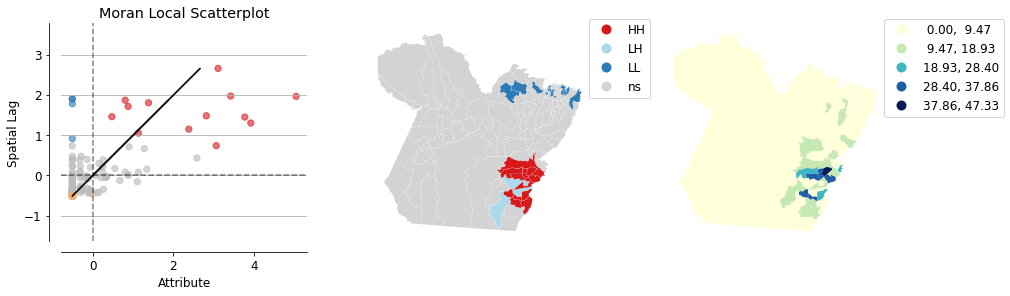

In [16]:
for ano in anos[5:]:
    y = para.loc[:, ano].values
    moran_loc = Moran_Local(y, w) 
    print(f'{ano}')
    plot_local_autocorrelation(moran_loc, gdf, ano, scheme='EqualInterval')
    plt.show()